# Свёрточные нейронные сети: CIFAR10

В этом ноутбке мы посмотрим, насколько хорошо CNN будут предсказывать классы на более сложном датасете картинок -- CIFAR10. 


## CIFAR10

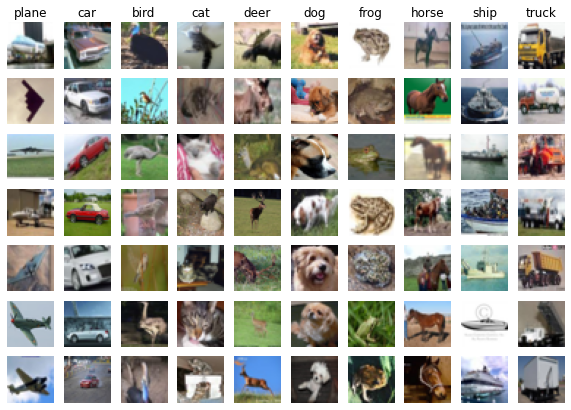

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

In [ ]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


cat


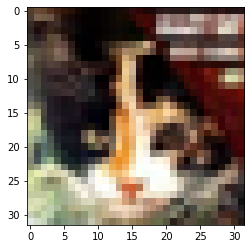

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i])
print (trainloader.dataset.classes[trainloader.dataset.targets[i]])

Напишем свёрточную нейросеть для предсказания на CIFAR10.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleConvNet(torch.nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(SimpleConvNet, self).__init__()
        # feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # classificator
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
from tqdm import notebook

In [ ]:
net = SimpleConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in notebook.tqdm(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # выводим качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

[1,  2000] loss: 2.049
[1,  4000] loss: 1.873
[1,  6000] loss: 1.764
[1,  8000] loss: 1.713
[1, 10000] loss: 1.664
[1, 12000] loss: 1.641



[2,  2000] loss: 1.585
[2,  4000] loss: 1.559
[2,  6000] loss: 1.542
[2,  8000] loss: 1.519
[2, 10000] loss: 1.505
[2, 12000] loss: 1.493



[3,  2000] loss: 1.444
[3,  4000] loss: 1.425
[3,  6000] loss: 1.406
[3,  8000] loss: 1.393
[3, 10000] loss: 1.396
[3, 12000] loss: 1.380


Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 25 %
Accuracy of   cat : 51 %
Accuracy of  deer : 36 %
Accuracy of   dog : 34 %
Accuracy of  frog : 62 %
Accuracy of horse : 63 %
Accuracy of  ship : 62 %
Accuracy of truck : 60 %


Проверим работу нейросети визуально (позапускайте ячейку несколько раз):

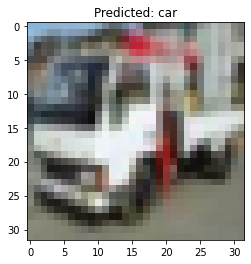

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Улучшим свёрточную нейросеть: поэкспериментируем с архитектурой (количество слоёв, порядок слоёв) и с гиперпараметрами (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое и др).

In [ ]:
class BetterConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(BetterConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(3 * 3 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
#         print(x.shape)
        x = x.view(-1, 3 * 3 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
net = BetterConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in notebook.tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

[1,  2000] loss: 1.970
[1,  4000] loss: 1.690
[1,  6000] loss: 1.582
[1,  8000] loss: 1.525
[1, 10000] loss: 1.459
[1, 12000] loss: 1.427



[2,  2000] loss: 1.375
[2,  4000] loss: 1.382
[2,  6000] loss: 1.372
[2,  8000] loss: 1.351
[2, 10000] loss: 1.349
[2, 12000] loss: 1.330



[3,  2000] loss: 1.289
[3,  4000] loss: 1.287
[3,  6000] loss: 1.275
[3,  8000] loss: 1.286
[3, 10000] loss: 1.269
[3, 12000] loss: 1.280



[4,  2000] loss: 1.217
[4,  4000] loss: 1.231
[4,  6000] loss: 1.217
[4,  8000] loss: 1.233
[4, 10000] loss: 1.229
[4, 12000] loss: 1.228



[5,  2000] loss: 1.171
[5,  4000] loss: 1.197
[5,  6000] loss: 1.170
[5,  8000] loss: 1.185
[5, 10000] loss: 1.207
[5, 12000] loss: 1.200


Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 71 %
Accuracy of  bird : 34 %
Accuracy of   cat : 41 %
Accuracy of  deer : 59 %
Accuracy of   dog : 38 %
Accuracy of  frog : 57 %
Accuracy of horse : 65 %
Accuracy of  ship : 61 %
Accuracy of truck : 68 %


Если качество ~70% в среднем, то текущая нейросеть вполне неплоха (однако на этом датасете известны архитектуры, дающие 95+% качества).

Посмотрим визуально на работу нейросети:

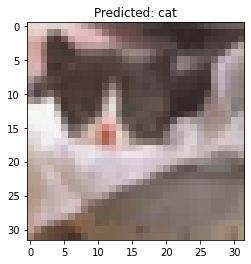

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image) 
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Попробуем обучить ещё более сильную нейросеть:

In [ ]:
class StrongConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(StrongConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(4 * 4 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
#         print(x.shape)
        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Обучим:

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
net = StrongConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 5

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
learning_rate = 1e-3
# новая фишка - динамически изменяем LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in notebook.tqdm(range(num_epochs)):
    
    scheduler.step()
    
    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,  2000] loss: 1.876
[1,  4000] loss: 1.676
[1,  6000] loss: 1.583
[1,  8000] loss: 1.522
[1, 10000] loss: 1.462
[1, 12000] loss: 1.436



[2,  2000] loss: 1.313
[2,  4000] loss: 1.282
[2,  6000] loss: 1.246
[2,  8000] loss: 1.232
[2, 10000] loss: 1.231
[2, 12000] loss: 1.214



[3,  2000] loss: 1.122
[3,  4000] loss: 1.070
[3,  6000] loss: 1.076
[3,  8000] loss: 1.057
[3, 10000] loss: 1.077
[3, 12000] loss: 1.072



[4,  2000] loss: 0.994
[4,  4000] loss: 0.976
[4,  6000] loss: 0.957
[4,  8000] loss: 1.007
[4, 10000] loss: 0.980
[4, 12000] loss: 0.931



[5,  2000] loss: 0.930
[5,  4000] loss: 0.936
[5,  6000] loss: 0.943
[5,  8000] loss: 0.922
[5, 10000] loss: 0.944
[5, 12000] loss: 0.947


Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 78 %
Accuracy of  bird : 47 %
Accuracy of   cat : 40 %
Accuracy of  deer : 53 %
Accuracy of   dog : 51 %
Accuracy of  frog : 71 %
Accuracy of horse : 69 %
Accuracy of  ship : 73 %
Accuracy of truck : 70 %


Посмотрим визуально на работу нейросети:

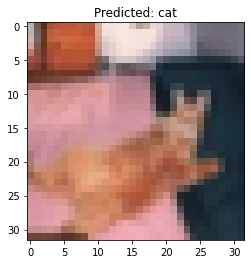

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Даже обучив более глубокую и прокаченную (BatchNorm, Dropout) нейросеть на этих данных мы видим, что качество нас всё ещё не устраивает (чуть больше 62%). Как же быть, ведь свёрточные нейросети должны хорошо классифицировать изображения?  

К сожалению, обучение нейросети с нуля на не очень большой выборке (а здесь она именно такая) часто приводит к переобучению, что плохо сказывается на тестовом качестве.  

Для того, чтобы получить более качественную модель, часто **до**обучают сильную нейросеть, обученную на [ImageNet](http://www.image-net.org/), то есть используют технику Transfer Learning. 

В PyTorch уже есть такие модели: https://pytorch.org/docs/stable/torchvision/models.html. Например, для классификации:

* AlexNet
* VGG
* ResNet
* SqueezeNet
* DenseNet
* Inception v3
* GoogLeNet
* ShuffleNet v2
* MobileNet v2
* ResNeXt
* Wide ResNet
* MNASNet
